## PyCity_Calc tutorial

This is a tutorial on how to use pycity_calc. 

PyCity_Calc is an addon for pycity. It extends pycity with calculation methods for energy balances and economic calculation, primarily on an annual basis. 

Pycity_Calc depends on uesgraphs and pycity package.

First, you should download and install uesgraph. 
https://github.com/RWTH-EBC/uesgraphs

Local installation is possible via pip:

`pip install -e 'your_path_to_uesgraphs_setup'`

Second, you should install pycity via pip:
https://github.com/RWTH-EBC/pyCity

`pip install -e 'your_path_to_pycity_setup'`

Now you should fulfill all requirements to work with pycity_calc.

Next, you should install pycity_calc:
https://egitlab.eonerc.rwth-aachen.de/jsc/pycity_calculator.git

`pip install -e 'your_path_to_pycity_calc_setup'`

### Part 1: pycity_calc environment

Equivalent to pycity, every object points to an environment class. Pycity_calc holds an own environment class, which is an extension of the environment class of pycity. It still holds the original weather object of pycity. However, timer and prices have been extended. Furthermore, an co2emissions about has been added.

Now we will generate an extended environment:

In [1]:
import pycity_base.classes.Weather as Weather

import pycity_calc.environments.co2emissions as co2
import pycity_calc.environments.environment as env
import pycity_calc.environments.market as mark
import pycity_calc.environments.timer as time


#  Input parameters
year = 2010  # Reference year
timestep = 3600  # Timestep in seconds
location = (51.529086, 6.944689)  # (latitude, longitute) of location
altitude = 55  # altitude of location in m

#  Generate extended timer object
timer = time.TimerExtended(timestep=timestep, year=year)

print('Timestep of timer:')
print(timer.timeDiscretization)
print('Number of timesteps:')
print(int(timer.timestepsHorizon))
print('Final timestep in hours:')
print(int(timer.timestepsHorizon * timer.timeDiscretization / 3600))
print('Reference year:')
print(timer.year)

Timestep of timer:
3600
Number of timesteps:
8760
Final timestep in hours:
8760
Reference year:
2010


Important: In comparison to the timer object of pycity, timestepsHorizon and timestepsUsedHorizon are set equal to total number of timesteps. TimeDiscretization and timestepsTotal always lead to a full year analysis. Thus, TimerExtended is not suitable for methods, like rolling horizon. Its made for energy and economic analysis with annual scope.

Now we are going to generate a weather object (same as in pycity)

In [2]:
#  Generate weather object
weather = Weather.Weather(timer, useTRY=True, location=location,
                          altitude=altitude)

print('Weather object ', weather)

Weather object  <pycity_base.classes.Weather.Weather object at 0x0000000004B13F98>


Next, we are going to generate pycity_calc market, co2emissions and environment object

In [3]:
#  Generate market object
market = mark.Market()
#  Market is an inheritance of pycity prices object

#  Generate co2 emissions object (new in pycity_calc)
co2em = co2.Emissions(year=year)

#  Generate environment
environment = env.EnvironmentExtended(timer, weather, prices=market,
                                      location=location, co2em=co2em)

#  Show current timestep
print('Time discretization in seconds:')
print(environment.timer.timeDiscretization)

#  Show weather forecast for outdoor temperature (only extract the first 10 timestep values)
print('\nShow outdoor tempreature forecast:')
print(environment.weather.getWeatherForecast(getTAmbient=True)[0][:10])

Time discretization in seconds:
3600

Show outdoor tempreature forecast:
[ 2.1  1.   0.1  0.   0.   0.2  0.1  0.1  0.   0.2]


### Part 2: BuildingExtended

pycity_calc holds its own building class, called BuildingExtended. It is an inheritance of the building class of pycity. 
It holds further attributes (such as nb_of_floors etc., mainly required for TEASER usage) and methods (mainly for returning annual demand values).

The procedure to generate a building is the same as within pycity. However, instead of using a Building object, a BuildingExtended object is used. 

First, we going to generate loads of pycity:

Space heating power curve in Watt:
[ 2040.33568064  2093.56182883  2146.78797702 ...,  2556.3623823
  1745.09669477  1272.34474736]


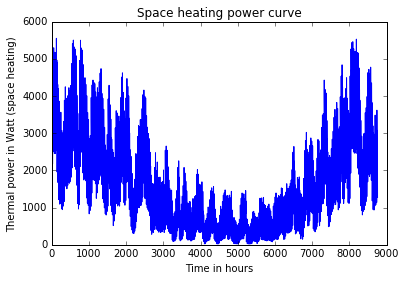

In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import pycity_base.classes.demand.DomesticHotWater as DomesticHotWater
import pycity_base.classes.demand.ElectricalDemand as ElectricalDemand
import pycity_base.classes.demand.SpaceHeating as SpaceHeating

#  Generate space heating load object
space_heating = SpaceHeating.SpaceHeating(environment, method=1,
                                          livingArea=150,
                                          specificDemand=100)
#  Method 1 --> Use standardized load profile (SLP)
#  Annual demand is calculated product of livingArea and specificDemand

#  Show space heating power curve in Watt
print('Space heating power curve in Watt:')
print(space_heating.get_power(currentValues=False))
#  currentValues = False --> Show values for all timesteps
#  (not only for forecast horizon)

#  Plot curve
plt.plot(space_heating.get_power(currentValues=False))
plt.xlabel('Time in hours')
plt.ylabel('Thermal power in Watt (space heating)')
plt.title('Space heating power curve')
plt.show()

In [5]:
#  Generate electrical load object
el_demand = ElectricalDemand.ElectricalDemand(environment,
                                              method=1,
                                              annualDemand=3000)
#  Method 1 --> Use standardized load profile (SLP)

print('Electrical load in W:')
print(el_demand.get_power(currentValues=False))

Electrical load in W:
[  81.60684    75.637881   69.94872  ...,  101.391264   95.160516
   88.835364]


In [6]:
#  Generate domestic hot water object via Annex 42 data
dhw_annex42 = DomesticHotWater.DomesticHotWater(environment,
                                                tFlow=60,
                                                thermal=True,
                                                method=1,
                                                dailyConsumption=70,
                                                supplyTemperature=25)
#  Method 1 --> Use Annex 42 data

print('Hot water power load in W:')
print(dhw_annex42.get_power(currentValues=False, returnTemperature=False))

Hot water power load in W:
[   0.            0.            0.         ...,  659.97555556    0.            0.        ]


Next, we are going to generate an pycity apartment and add the load objects

In [7]:
import pycity_base.classes.demand.Apartment as Apartment

#  Initialize apartment object
apartment = Apartment.Apartment(environment)

#  Add single entity to apartment
apartment.addEntity(space_heating)

#  Add multiple entities to apartment
apartment.addMultipleEntities([el_demand, dhw_annex42])

Besides load profiles, occupancy profiles can be added to the apartment

Now we are going to generate a BuildingExtended object

In [11]:
import pycity_calc.buildings.building as build_ex

#  Create extended building object
extended_building = build_ex.BuildingExtended(environment, build_year=1962,
                                             mod_year=2003, build_type=0)
#  BuildingExtended holds further, optional input parameters,
#  such as ground_area, nb_of_floors etc.

#  Add apartment to extended building
extended_building.addEntity(entity=apartment)

#  Return building type integer number
print('Building type number: ', extended_building.build_type)

#  Return space heating power curve
print('\nGet building space heating power curve:')
print(extended_building.get_space_heating_power_curve())

#  Return electrical power curve
print('\nGet building electrical power curve:')
print(extended_building.get_electric_power_curve())

#  Return domestic hot water power curve
print('\nGet building hot water power curve:')
print(extended_building.get_dhw_power_curve())

Building type number:  0

Get building space heating power curve:
[ 2040.33568064  2093.56182883  2146.78797702 ...,  2556.3623823
  1745.09669477  1272.34474736]

Get building electrical power curve:
[  81.60684    75.637881   69.94872  ...,  101.391264   95.160516
   88.835364]

Get building hot water power curve:
[   0.            0.            0.         ...,  659.97555556    0.            0.        ]


BuildingExtended holds further methods, e.g. for returning annual demand values:

In [15]:
ann_heat_demand = extended_building.get_annual_space_heat_demand()

#  Return space heating power curve
print('\nGet annual space heating energy demand:')
print(ann_heat_demand)

ann_el_demand = extended_building.get_annual_el_demand()

#  Return electrical power curve
print('\nGet annual electrical energy demand:')
print(str(round(ann_el_demand, 0)))

ann_dhw_demand = extended_building.get_annual_dhw_demand()
      
#  Return domestic hot water power curve
print('\nGet annual hot water energy demand:')
print(str(round(ann_dhw_demand, 0)))


Get annual space heating energy demand:
15000.0

Get annual electrical energy demand:
3000.0

Get annual hot water energy demand:
1134.0
